<a href="https://colab.research.google.com/github/Shellyga/Adversarial-Domain-Adaptation-with-Keras/blob/master/Binary_Final_Version_Adversarial_Domain_Adaptation_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model

In [1]:
pip install keras_vggface

In [2]:
import random
import numpy as np
from keras.models import Model,clone_model
from keras.applications.resnet50 import ResNet50
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense,Reshape
from keras.layers import BatchNormalization, Activation, Dropout
from keras_vggface.vggface import VGGFace



def build_embedding(param):
    inp = Input(shape= param["inp_dims"])
    network = eval('VGGFace')
    base = network(weights = 'vggface', include_top = False)
    # base = network(weights = 'imagenet', include_top = False)
    feat = base(inp)
    return Model(inp,feat)
    # print(feat.shape)
    # flat = Flatten()(feat)
    # return flat

# def build_embedding(param,inp):
#     model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), weights='vggface', pooling='avg')
#     feat = model.get_layer('avg_pool').output
#     # return feat
#     # print(feat.shape)
#     flat = Flatten()(feat)
#     # flat = Reshape((-1,))(feat)
#     # flat = Flatten()(embedding)
#     # print(flat.shape)
#     return flat

def build_classifier(param, embedding):
    # embedding = Input(embedding.shape)
    # embedding = Input( (None, 100352) )
    # embedding = Input( embedding.output)
    # embedding = Reshape((-1,))(embedding)
    flat = Flatten()(embedding.output)
    dense1 = Dense(400, name = 'class_dense1')(flat)
    bn1 = BatchNormalization(name = 'class_bn1')(dense1)
    act1 = Activation('relu', name = 'class_act1')(bn1)
    drop2 = Dropout(param["drop_classifier"], name = 'class_drop1')(act1)

    dense2 = Dense(100, name = 'class_dense2')(drop2)
    bn2 = BatchNormalization(name = 'class_bn2')(dense2)
    act2 = Activation('relu', name = 'class_act2')(bn2)
    drop2 = Dropout(param["drop_classifier"], name = 'class_drop2')(act2)
    densel = Dense(param["number_of_classe"], name = 'class_dense_last')(drop2)
    # densel = Dense(param["source_label"].shape[1], name = 'class_dense_last')(drop2)
    bnl = BatchNormalization(name = 'class_bn_last')(densel)
    actl = Activation('softmax', name = 'class_act_last')(bnl)
    return Model(inputs=(embedding.input), outputs=(actl))

def build_discriminator(param, embedding_shape):
    # embedding = Input(embedding.shape)
    # embedding = Input( (None, 100352) )
    embedding = Input( embedding_shape )
    # embedding = Reshape((-1,))(embedding)
    flat = Flatten()(embedding)
    dense1 = Dense(400, name = 'dis_dense1')(flat)
    bn1 = BatchNormalization(name='dis_bn1')(dense1)
    act1 = Activation('relu', name = 'dis_act1')(bn1)
    drop1 = Dropout(param["drop_discriminator"], name = 'dis_drop1')(act1)

    dense2 = Dense(100, name = 'dis_dense2')(drop1)
    bn2 = BatchNormalization(name='dis_bn2')(dense2)
    act2 = Activation('relu', name = 'dis_act2')(bn2)
    drop2 = Dropout(param["drop_discriminator"], name = 'dis_drop2')(act2)

    densel = Dense(1, name = 'dis_dense_last')(drop2)
    bnl = BatchNormalization(name = 'dis_bn_last')(densel)
    actl = Activation('sigmoid', name = 'dis_act_last')(bnl)
    return Model(input=embedding, outputs=actl)

# def build_combined_classifier(inp, classifier):
#     comb_model = Model(inputs = inp, outputs = [classifier])
#     return comb_model

# def build_combined_discriminator(inp, discriminator):
#     comb_model = Model(inputs = inp, outputs = [discriminator])
#     return comb_model

# def build_combined_model(inp, comb):
#     comb_model = Model(inputs = inp, outputs = comb)
#     return comb_model

Using TensorFlow backend.


# Optimizer

In [3]:
import numpy as np
from keras.optimizers import Adam

def opt_classifier(param):
    return Adam(lr=param["lr_classifier"], beta_1=param["b1_classifier"], beta_2=param["b2_classifier"])

def opt_discriminator(param):
    return Adam(lr=param["lr_discriminator"], beta_1=param["b1_discriminator"], beta_2=param["b2_discriminator"])

def opt_combined(param):
    return Adam(lr=param["lr_combined"], beta_1=param["b1_combined"], beta_2=param["b2_combined"])


# Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
SEED = 7
import os
import sys
import argparse
import random
import numpy as np
# import tensorflow.python.keras as tf
from tensorflow.compat.v1 import set_random_seed
# import tensorflow.python.keras as tf
from sklearn.model_selection import train_test_split
from sklearn import metrics
from plotnine import *
import pandas as pd
                
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from math import ceil
from sklearn.utils import shuffle as skshuffle

from imutils import paths
from sklearn.preprocessing import LabelEncoder

os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
set_random_seed(SEED)
random.seed(SEED)

from PIL import Image
from keras.utils import to_categorical
from keras.layers import Input
from keras.optimizers import Adam
from keras.utils import multi_gpu_model
from sklearn.metrics import accuracy_score
import pickle

from keras.preprocessing import image
def pil_loader(path):
    # print(path)
    # Return the RGB variant of input image
    with open(path, 'rb') as f:
      with Image.open(f) as img:
        return img.convert('RGB')

def one_hot_encoding(param):
    lb = LabelEncoder()
    source_labels,target_labels  = lb.fit_transform( param["source_label"]),lb.fit_transform( param["target_label"])
    param["number_of_classe"] = len(lb.classes_)
    source_labels,target_labels = to_categorical(source_labels),to_categorical(target_labels)
    f = open('/content/drive/My Drive/pro_data/‏final_result_B/labels',"wb")
    f.write(pickle.dumps(lb))
    f.close()
    return source_labels,target_labels

            
def data_loader(filepath, inp_dims):

    img = []
    label = []
    detector = dlib.get_frontal_face_detector()
    predictor = "drive/My Drive/pro_data/shape_predictor_5_face_landmarks.dat"
    imagePaths = sorted(list(paths.list_images(filepath)))
    # print(imagePaths)
    # loop over the input images
    for imagePath in imagePaths:
        # extract the class label from the image path and update the
        # labels list
        l = imagePath.split(os.path.sep)[-2]
        label.append(l)
        # i = pil_loader(imagePath)
        i = image.load_img(imagePath)
        # keras.preprocessing.image.img_to_array(image)
        i = i.resize((inp_dims[0], inp_dims[1]), Image.ANTIALIAS)
        frame_1 = align_and_crop(detector, np.array(i), predictor)[0]
        frame_1 = cv2.resize(frame_1,(inp_dims[0], inp_dims[1]))
        img.append(frame_1)
    img = np.array(img)
    label = np.array(label)
    return img, label
    

def batch_generator(data, batch_size):
    #Generate batches of data.
    all_examples_indices = len(data[0])
    while True:
        mini_batch_indices = np.random.choice(all_examples_indices, size = batch_size, replace = False)
        tbr = [k[mini_batch_indices] for k in data]
        yield tbr


In [15]:
def _plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, roc_curve, auc, confusion_matrix
    import itertools
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black")

    plt.ylabel('True Class', fontsize = 14)
    plt.xlabel('Predicted Class', fontsize = 14)

    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()

# Crop

In [6]:
import dlib

import os
import sys
import cv2
import glob


def align_and_crop(detector, im_to_align, predictor_path):
    '''
    simply aligns the photo (using the detector to identify the eyes) and crops the face.
    :param im_to_align: an address of an image
    '''

    # a shape predictor to find face landmarks so we can precisely localize
    # the face
    sp = dlib.shape_predictor(predictor_path)

    # Ask the detector to find the bounding boxes of each face. The 1 in the
    # second argument indicates that we should upsample the image 1 time.
    try:
        dets = detector(im_to_align, 1)
    except RuntimeError:
        return -1

    num_faces = len(dets)
    if num_faces == 0:
        return im_to_align, False

    # Find the 5 face landmarks we need to do the alignment.
    faces = dlib.full_object_detections()
    for detection in dets:
        faces.append(sp(im_to_align, detection))

    # get a single chip (aligned and cropped)
    image = dlib.get_face_chip(im_to_align, faces[0])
    # cv2.imshow("f", image) show image for testing
    return image, True

# Augment

In [7]:
from imgaug import augmenters as iaa
from imgaug import seed
def aug_training_set_loader(images,labels,inp_dims):
    NUM_COPIES = ceil(1000/len(images))
    images = np.array(images)
    images=augment(inp_dims[0], inp_dims[1], images, NUM_COPIES)
    aug_labels =[]
    for x in labels:
        for i in range(NUM_COPIES+1):  # NUM_COPIES+1-> numbers of augmentations + 1 original
            aug_labels.append(x)
    images, labels = skshuffle(images, aug_labels)
    images = np.array(images)
    # images = np.array(images, dtype="float") / 255.0
    labels = np.array(labels)
    return images, labels

def augment(width, height, data, NUM_COPIES):
    """
    preform augmentetion on the list of photos named 'data'
    :param width: width of a single photo
    :param height: height of a single photo
    :param data: a list of photos to augment
    :param NUM_COPIES: number of copies produced from the image
    :return: a list of photos that consists from the original photos and their augmentations
    """
    augmented_data = []
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    seq = iaa.Sequential([
        sometimes(iaa.Sharpen(alpha=(0.0, 1.0), lightness=(0.75, 2.0))),
        sometimes(iaa.Fliplr()),  # horizontal flips
        sometimes(iaa.AddElementwise((-50, 50))),
        sometimes(iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0.0, 2.0)))),
        sometimes(iaa.ContrastNormalization((0.8, 1.2))),
        sometimes(iaa.Multiply((0.8, 1.2), per_channel=0.2)),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            shear=(-8, 8)
        )),
        sometimes(iaa.Superpixels(p_replace=0.1, n_segments=150))
    ], random_order=True)  # apply augmenters in random order
    for img in data:
        copies = augment_image(width, height, img, seq, NUM_COPIES)
        copies.append(img.reshape(width, height, 3))
        for cpy in copies:
            augmented_data.append(cpy)
    return augmented_data


def augment_image(width, height, image, seq, NUM_COPIES):
    """
        augments a single image
    :param width: width of the image
    :param height: height of the image
    :param image: a matrix representing a rgb image
    :param seq: the augmantation sequence preformed
    :param NUM_COPIES: number of copies produced from the image
    :return: a list of all images made from 'image' not including the original
    """
    seed (1)
    copies = []
    image = image.reshape(width, height, 3)
    for i in range(NUM_COPIES):
        copies.append(seq.augment_image(image))

    return copies

# Only Classifier

In [8]:
def train_classifier(param,models):
    
    inp = Input(shape = ([224, 224, 3]))
    # embedding = build_embedding_vgg(param,inp)
    # classifier = build_classifier_vgg(param, embedding)
    
    models["combined_classifier"].compile(optimizer = opt_classifier(param), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    Xs_train, ys_train = param["Xs_train"], param["ys_train"]
    Xs_test , ys_test =  param["Xs_test"], param["ys_test"]
    S_batches = batch_generator([Xs_train, ys_train], param["batch_size"])
    # T_batches = batch_generator([Xt_train, np.zeros(shape = (len(Xt_train),))], param["batch_size"])

    param["target_accuracy"] = 0

    optim = {}
    optim["iter"] = 0
    optim["acc"] = ""
    # optim["labels"] = np.array(Xt.shape[0],)
    gap_last_snap = 0

    acc_source=[]
    acc_target=[]
    acc_domain_source=[]
    acc_domain_target=[]

    for i in range(param["num_iterations_classifier"]):        
        Xsb, ysb = next(S_batches)
        # Xtb, ytb = next(T_batches)
 
        stats1 = models["combined_classifier"].train_on_batch(Xsb, [ysb])

        if ((i + 1) % param["test_interval"] == 0):
            ys_pred = models["combined_classifier"].predict(Xs_train)
            # yt_pred = models["combined_classifier"].predict(Xt_train)

            source_accuracy = accuracy_score(ys_train.argmax(1), ys_pred.argmax(1))              
            # target_accuracy = accuracy_score(yt_train.argmax(1), yt_pred.argmax(1))


            acc_source.append(source_accuracy)
            # acc_target.append(target_accuracy)

            log_str = "iter: {:05d}: \nLABEL CLASSIFICATION: source_accuracy: {:.5f}"\
                                                         .format(i, source_accuracy*100)
            print(log_str)

            
            
    models["combined_classifier"].save('/content/drive/My Drive/pro_data/‏final_result_B/source_classifier.h5')

    print("Source matrix: ",metrics.confusion_matrix(ys_train.argmax(1), ys_pred.argmax(1)))

    ys_test_pred = models["combined_classifier"].predict(Xs_test)
    source_accuracy_test = accuracy_score(ys_test.argmax(1), ys_test_pred.argmax(1))              

    print("source accuracy test",source_accuracy_test)
    cm_s = metrics.confusion_matrix(ys_test.argmax(1), ys_test_pred.argmax(1))
    print("Source matrix: ",cm_s)
    
    labels_path = '/content/drive/My Drive/pro_data/‏final_result_B/labels'  
    lb = pickle.loads(open(labels_path, "rb").read())
    classes = lb.classes_
    _plot_confusion_matrix(cm_s, classes,title='Classifier Source Confusion matrix')

    N = np.arange(0,len(acc_source))

    plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, np.array(acc_source), label="Source accuracy")
    plt.title("Training Accuracy of Source Classifier ")
    plt.xlabel("Number of imtervals")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig('/content/drive/My Drive/pro_data/‏final_result_B/classifier.png')

    plt.show()




# Train target discriminator 

In [9]:
models = {}
from keras.applications.vgg16 import preprocess_input
def train(param):
    inp = Input(shape = (param["inp_dims"]))
    models["embedding_s"] = build_embedding(param) 
    # Build the classifier
    models['combined_classifier'] = build_classifier(param,  models["embedding_s"])
    train_classifier(param,models)

    embedding_t = clone_model( models["embedding_s"])
    
    # Build and compile the discriminator
    discriminator_s = build_discriminator(param,  models["embedding_s"].output_shape[1:])
    discriminator_t = build_discriminator(param, embedding_t.output_shape[1:])
    models["combined_discriminator_s"] = Model(inputs=( models["embedding_s"].input), outputs=(discriminator_s( models["embedding_s"].output)))
    models["combined_discriminator_t"] = Model(inputs=(embedding_t.input), outputs=(discriminator_t(embedding_t.output)))
    models["combined_discriminator_t"].compile(optimizer = opt_discriminator(param), loss = 'binary_crossentropy', metrics = ['accuracy'])
    #  If you set this flag after compilation - then it will not affect your model at all.
    # models["embedding_s"].trainable = False
    for layer in param["source_encoder"].layers:
        layer.trainable = False
    models["combined_discriminator_s"].compile(optimizer = opt_discriminator(param), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    
    models["combined_discriminator_s"].summary()
    models["combined_discriminator_t"].summary()
    
    Xt, Xt_test, yt, yt_test = param["Xt_train"], param["Xt_test"], param["yt_train"], param["yt_test"] 
    Xs, Xs_test, ys, ys_test = param["Xs_train"], param["Xs_test"], param["ys_train"], param["ys_test"] 

    
    Xs, ys = aug_training_set_loader(Xs, ys, param["inp_dims"])
    Xt, yt = aug_training_set_loader(Xt, yt, param["inp_dims"])


    # Source domain is represented by label 0 and Target by 1

    S_batches = batch_generator([Xs, ys], param["batch_size"])
    T_batches = batch_generator([Xt, np.zeros(shape = (len(Xt),))], param["batch_size"])

    param["target_accuracy"] = 0

    optim = {}
    optim["iter"] = 0
    optim["acc"] = ""
    optim["labels"] = np.array(Xt.shape[0],)
    gap_last_snap = 0

    acc_domain_source=[]
    acc_domain_target=[]
    loss_discriminator = []

    t_domain_label = np.ones(( param["batch_size"], 1))
    s_domain_label = np.zeros(( param["batch_size"], 1))
    for i in range(param["num_iterations_discriminator"]):        
        Xsb, ysb = next(S_batches)
        Xtb, ytb = next(T_batches)
        t_domain_label = np.zeros(Xsb.shape[0])
        s_domain_label =  np.ones(Xtb.shape[0])
        X_adv = np.concatenate([Xsb, Xtb])
        y_class = np.concatenate([ysb, np.zeros_like(ysb)])


        acc_d_s , d_loss_s = models["combined_discriminator_s"].train_on_batch(Xsb, s_domain_label)
        acc_d_t , d_loss_t = models["combined_discriminator_t"].train_on_batch(Xtb, t_domain_label)
        acc = acc_d_s + acc_d_t / 2
        loss = d_loss_s + d_loss_t

        if ((i + 1) % param["test_interval"] == 0):

            acc_domain_source.append(acc_d_s)
            acc_domain_target.append(acc_d_t)
            loss_discriminator.append(loss)

            log_str = "iter: {:05d}: DOMAIN DISCRIMINATION: source_domain_accuracy: {:.5f}, target_domain_accuracy: {:.5f} \n"\
                                                         .format(i, acc_d_s*100, acc_d_t*100)
            print(log_str)

    
    discriminator_t.save_weights('/content/drive/My Drive/pro_data/‏final_result_B/disc_target_10000_iter.hdf5')

    N = np.arange(0,len(acc_domain_source))

    plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, np.array(acc_domain_source), label="Domain Source accuracy")
    plt.plot(N, np.array(acc_domain_target), label="Domain Target accuracy")
    plt.title("Domain Accuracy of Source and Target ")
    plt.xlabel("Number of intervals")
    plt.ylabel("Accuracy")
    plt.legend()
  
    plt.savefig('/content/drive/My Drive/pro_data/‏final_result_B/discriminator_graph.png')
    plt.show()
    
    plt.style.use("ggplot")
    plt.figure()
    # plt.plot(N, np.array(loss_classifier_source), label="Combined Model ACC / Loss")
    plt.plot(N, np.array(loss_discriminator), label="Discriminator Acc / loss")
    plt.title("Discriminator Loss - Average of Source and Target ")
    plt.xlabel("Number of intervals")
    plt.ylabel("Acc/ Loss")
    plt.legend()
    
    plt.savefig('/content/drive/My Drive/pro_data/‏final_result_B/train_on_batch_graph.png')
    plt.show()


In [21]:
models["combined_discriminator_s"].summary()
models["combined_discriminator_t"].summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
vggface_vgg16 (Model)        multiple                  14714688  
_________________________________________________________________
model_5 (Model)              (None, 1)                 10077805  
Total params: 24,792,493
Trainable params: 24,791,491
Non-trainable params: 1,002
_________________________________________________________________
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
vggface_vgg16 (Model)        multiple                  14714688  
__________________________

# Main

In [12]:
import argparse
if __name__ == "__main__":
    # Read parameter values from the console
    parser = argparse.ArgumentParser(description = 'Domain Adaptation')
    parser.add_argument('--number_of_gpus', type = int, nargs = '?', default = '1', help = "Number of gpus to run")
    parser.add_argument('--network_name', type = str, default = 'ResNet50', help = "Name of the feature extractor network")
    parser.add_argument('--dataset_name', type = str, default = 'Office', help = "Name of the source dataset")
    parser.add_argument('--dropout_classifier', type = float, default = 0.25, help = "Dropout ratio for classifier")
    parser.add_argument('--dropout_discriminator', type = float, default = 0.25, help = "Dropout ratio for discriminator")    
    parser.add_argument('--source_path', type = str, default = 'amazon_10_list.txt', help = "Path to source dataset")
    parser.add_argument('--target_path', type = str, default = 'webcam_10_list.txt', help = "Path to target dataset")
    parser.add_argument('--lr_classifier', type = float, default = 0.0001, help = "Learning rate for classifier model")
    parser.add_argument('--b1_classifier', type = float, default = 0.9, help = "Exponential decay rate of first moment \
                                                                                             for classifier model optimizer")
    parser.add_argument('--b2_classifier', type = float, default = 0.999, help = "Exponential decay rate of second moment \
                                                                                            for classifier model optimizer")
    parser.add_argument('--lr_discriminator', type = float, default = 0.00001, help = "Learning rate for discriminator model")
    parser.add_argument('--b1_discriminator', type = float, default = 0.9, help = "Exponential decay rate of first moment \
                                                                                             for discriminator model optimizer")
    parser.add_argument('--b2_discriminator', type = float, default = 0.999, help = "Exponential decay rate of second moment \
                                                                                            for discriminator model optimizer")
    parser.add_argument('--lr_combined', type = float, default = 0.00001, help = "Learning rate for combined model")
    parser.add_argument('--b1_combined', type = float, default = 0.9, help = "Exponential decay rate of first moment \
                                                                                             for combined model optimizer")
    parser.add_argument('--b2_combined', type = float, default = 0.999, help = "Exponential decay rate of second moment \
                                                                                            for combined model optimizer")
    parser.add_argument('--classifier_loss_weight', type = float, default = 1, help = "Classifier loss weight")
    parser.add_argument('--discriminator_loss_weight', type = float, default = 4, help = "Discriminator loss weight")
    parser.add_argument('--batch_size', type = int, default = 32, help = "Batch size for training")
    parser.add_argument('--test_interval', type = int, default = 3, help = "Gap between two successive test phases")
    parser.add_argument('--num_iterations', type = int, default = 120, help = "Number of iterations")
    parser.add_argument('--snapshot_interval', type = int, default = 500, help = "Minimum gap between saving outputs")
    parser.add_argument('--output_dir', type = str, default = 'Models', help = "Directory for saving outputs")
    # args = parser.parse_args()

    # Set GPU device
    # os.environ["CUDA_VISIBLE_DEVICES"] = str(list(np.arange(args.number_of_gpus))).strip('[]')

    # Initialize parameters
    param = {}
    models = {}
    param["number_of_gpus"] = 1
    # param["network_name"] = 'ResNet50'
    param["network_name"] = 'VGGFace'
    param["inp_dims"] = [224, 224, 3]
    param["num_iterations_classifier"] = 2000
    param["num_iterations_discriminator"] = 5000
    # param["num_iterations"] = 500
    param["lr_classifier"] = 0.0001
    param["b1_classifier"] = 0.9
    param["b2_classifier"] = 0.999    
    param["lr_discriminator"] = 0.00001
    param["b1_discriminator"] =  0.9
    param["b2_discriminator"] = 0.999
    param["lr_combined"] = 0.00001
    param["b1_combined"] =  0.9
    param["b2_combined"] =  0.999       
    # param["batch_size"] = int(32)
    param["batch_size"] = int(32/2)
    param["class_loss_weight"] = 1
    param["dis_loss_weight"] = 4    
    param["drop_classifier"] = 0.25
    param["drop_discriminator"] = 0.25
    param["test_interval"] = 100
    # param["source_path"] = 'drive/My Drive/final_proj_dataset/data_file_shelly.txt'
    # param["target_path"] = 'drive/My Drive/final_proj_dataset/data_file_yerus.txt' 
    param["source_path"] = '/content/drive/My Drive/pro_data/source'
    param["target_path"] =  '/content/drive/My Drive/pro_data/target'
    param["snapshot_interval"] = 500
    # param["snapshot_interval"] = 5
    param["output_path"] = '/content/drive/My Drive/pro_data/‏final_result_B'
    param["number_of_classe"] = 0

    # # Create directory for saving models and log files
    if not os.path.exists(param["output_path"]):
        os.mkdir(param["output_path"])
    
    # print("[INFO] loading images...")
    # # Load source and target data
    # param["source_data"], param["source_label"] = data_loader(param["source_path"], param["inp_dims"])
    # param["target_data"], param["target_label"] = data_loader(param["target_path"], param["inp_dims"])
    # # param["source_data"], param["source_label"],param["target_data"], param["target_label"] =  load_data(param["source_path"],param["target_path"])

    # # Encode labels into one-hot format
    # param["source_label"], param["target_label"] = one_hot_encoding(param)

    

   

In [13]:
print("[INFO] loading images...")
# Load source and target data
param["source_data"], param["source_label"] = data_loader(param["source_path"], param["inp_dims"])
print("source images loaded")
print("number of images in source domain", param["source_data"].shape[0])
param["target_data"], param["target_label"] = data_loader(param["target_path"], param["inp_dims"])
print("target images loaded")
print("number of images in target domain", param["target_data"].shape[0])
# Encode labels into one-hot format
print("[INFO] Encode labels into one-hot format")
param["source_label"], param["target_label"] = one_hot_encoding(param)



param["Xt_train"], param["Xt_test"], param["yt_train"], param["yt_test"] = train_test_split(param["target_data"], param["target_label"], test_size=0.2, random_state=42)
param["Xs_train"], param["Xs_test"], param["ys_train"], param["ys_test"] = train_test_split(param["source_data"], param["source_label"], test_size=0.2, random_state=42)

print('Xt_train ',param["Xt_train"].shape[0] )
print('Xt_test ',param["Xt_test"].shape[0])
print('Xs_train', param["Xs_train"].shape[0] )
print('Xs_test', param["Xs_test"].shape[0])

[INFO] loading images...
source images loaded
number of images in source domain 1050
target images loaded
number of images in target domain 1063
[INFO] Encode labels into one-hot format
Xt_train  850
Xt_test  213
Xs_train 840
Xs_test 210


[INFO] training network...
iter: 00099: 
LABEL CLASSIFICATION: source_accuracy: 99.88095
iter: 00199: 
LABEL CLASSIFICATION: source_accuracy: 100.00000
iter: 00299: 
LABEL CLASSIFICATION: source_accuracy: 100.00000
iter: 00399: 
LABEL CLASSIFICATION: source_accuracy: 100.00000
iter: 00499: 
LABEL CLASSIFICATION: source_accuracy: 100.00000
iter: 00599: 
LABEL CLASSIFICATION: source_accuracy: 100.00000
iter: 00699: 
LABEL CLASSIFICATION: source_accuracy: 100.00000
iter: 00799: 
LABEL CLASSIFICATION: source_accuracy: 100.00000
iter: 00899: 
LABEL CLASSIFICATION: source_accuracy: 100.00000
iter: 00999: 
LABEL CLASSIFICATION: source_accuracy: 100.00000
iter: 01099: 
LABEL CLASSIFICATION: source_accuracy: 100.00000
iter: 01199: 
LABEL CLASSIFICATION: source_accuracy: 100.00000
iter: 01299: 
LABEL CLASSIFICATION: source_accuracy: 100.00000
iter: 01399: 
LABEL CLASSIFICATION: source_accuracy: 100.00000
iter: 01499: 
LABEL CLASSIFICATION: source_accuracy: 100.00000
iter: 01599: 
LABEL CLASSIFIC

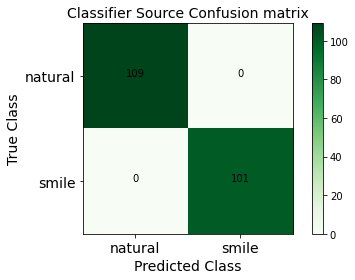

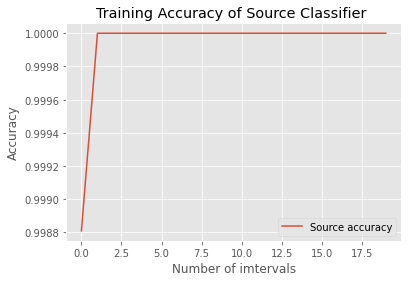

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("di..., inputs=Tensor("in...)`


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dis_dense1 (Dense)           (None, 400)               10035600  
_________________________________________________________________
dis_bn1 (BatchNormalization) (None, 400)               1600      
_________________________________________________________________
dis_act1 (Activation)        (None, 400)               0         
_________________________________________________________________
dis_drop1 (Dropout)          (None, 400)               0         
_________________________________________________________________
dis_dense2 (Dense)           (None, 100)               4010

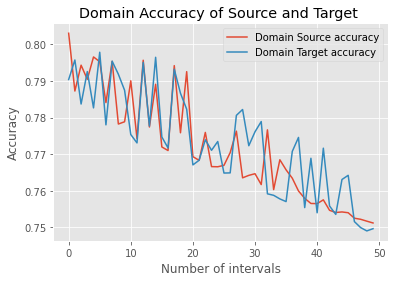

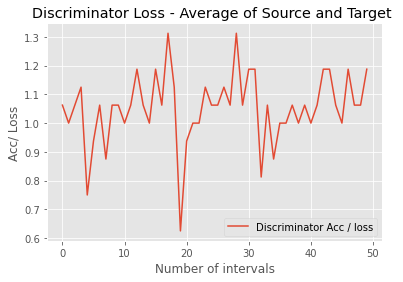

In [16]:
# Train data
print("[INFO] training network...")
train(param)
# param["combined_classifier"].save('drive/My Drive/pro_data/result_vgg_notBmix/_source_model_less_layers.h5')


# Target Classifier

In [17]:
from keras.models import load_model
path_source_classifier = '/content/drive/My Drive/pro_data/‏final_result_B/source_classifier.h5'
model = load_model(path_source_classifier)
path_target_discriminator = '/content/drive/My Drive/pro_data/‏final_result_B/disc_target_10000_iter.hdf5'
model.load_weights(path_target_discriminator, by_name=True)
# model.compile(optimizer = opt_classifier(param), loss = 'categorical_crossentropy', metrics = ['accuracy'])
test_xt,test_yt = param["Xt_test"], param["yt_test"]
yt_pred = model.predict(test_xt)
target_accuracy_test = accuracy_score(test_yt.argmax(1), yt_pred.argmax(1))              

cm_t = metrics.confusion_matrix(test_yt.argmax(1), yt_pred.argmax(1))

print("target accuracy test",target_accuracy_test)
print("target Classifier matrix: ",cm_t)


test_xs,test_ys = param["Xs_test"], param["ys_test"]
ys_pred = model.predict(test_xs)
source_accuracy_test = accuracy_score(test_ys.argmax(1), ys_pred.argmax(1))              
cm_s = metrics.confusion_matrix(test_ys.argmax(1), ys_pred.argmax(1))

print("source accuracy test",source_accuracy_test)
print("source Classifier matrix: ",cm_s)


target accuracy test 0.5305164319248826
target Classifier matrix:  [[21 90]
 [10 92]]
source accuracy test 1.0
source Classifier matrix:  [[109   0]
 [  0 101]]


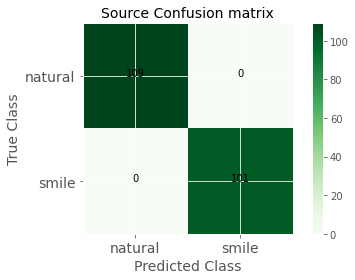

In [18]:
labels_path = '/content/drive/My Drive/pro_data/‏final_result_B/labels'  
lb = pickle.loads(open(labels_path, "rb").read())
classes = lb.classes_
_plot_confusion_matrix(cm_s, classes,title='Source Confusion matrix')


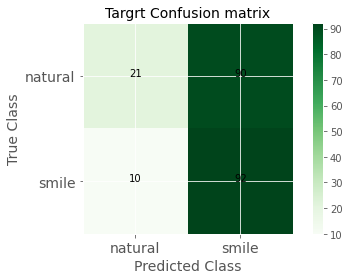

In [19]:
_plot_confusion_matrix(cm_t, classes,title='Targrt Confusion matrix')

# Sanity Check

target accuracy test 0.5305164319248826
target Classifier matrix:  [[21 90]
 [10 92]]


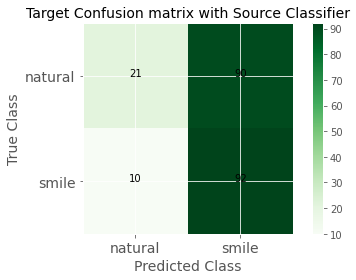

In [20]:
from keras.models import load_model
path_source_classifier = '/content/drive/My Drive/pro_data/‏final_result_B/source_classifier.h5'
source_model = load_model(path_source_classifier)

test_xt,test_yt = param["Xt_test"], param["yt_test"]
yt_pred = source_model.predict(test_xt)
target_accuracy_test = accuracy_score(test_yt.argmax(1), yt_pred.argmax(1))              

cm_t_sanity = metrics.confusion_matrix(test_yt.argmax(1), yt_pred.argmax(1))

print("target accuracy test",target_accuracy_test)
print("target Classifier matrix: ",cm_t)

_plot_confusion_matrix(cm_t_sanity, classes,title='Target Confusion matrix with Source Classifier')
